# ** TPS Jan 2022- Random Forest based ensemble approach with explanation ( score 4.63143) **


### this notebook is modified from excellent work of https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
# loading core libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations
import math
import statistics
import time
from datetime import datetime
import matplotlib.dates as mdates
import dateutil.easter as easter

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge

# Models
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [ ]:
### Loading initial data
train_data=pd.read_csv('../input/tabular-playground-series-jan-2022/train.csv', index_col='row_id')
test_data=pd.read_csv('../input/tabular-playground-series-jan-2022/test.csv', index_col='row_id')

# Shape and preview
print('Training data df shape:',train_data.shape)
print('Test data df shape:',test_data.shape)
train_data.head()

In [ ]:
# loading the test data, as we can see below num_sold column is missing which is objective. 
# We need to predict num_sold in future time series.
test_data.head()

### So far Notebook has not recorgnized the date column is acutally time in date format. We need to assign accordingly

In [ ]:
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
# Convert date to datetime

train_data.date=pd.to_datetime(train_data.date)
test_data.date=pd.to_datetime(test_data.date)

# drop 29th Feb
train_data.drop(train_data[(train_data.date.dt.month==2) & (train_data.date.dt.day==29)].index, axis=0, inplace=True)

In [ ]:
#lets visualize the data
train_data.head()

## **Visalizing the data which has been loaded sofar.**

In [ ]:
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
# Figure
plt.figure(figsize=(12,5))

# Groupby
aa=train_data.groupby(['date','store']).agg(num_sold=('num_sold','sum'))

# Lineplot
sns.lineplot(data=aa, x='date', y='num_sold', hue='store')

# Aesthetics
plt.title('num_sold by store')

In [ ]:
# plotting number of iteams sold indepenpently 
#ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
# Subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Groupby
KR=train_data[train_data.store=='KaggleRama']
KM=train_data[train_data.store=='KaggleMart']
bb=KR.groupby(['date','product']).agg(num_sold=('num_sold','sum'))
cc=KM.groupby(['date','product']).agg(num_sold=('num_sold','sum'))

# Lineplots
ax1=sns.lineplot(ax=axes[0], data=bb, x='date', y='num_sold', hue='product')
ax2=sns.lineplot(ax=axes[1], data=cc, x='date', y='num_sold', hue='product')

# Aesthetics
ax1.title.set_text('KaggleRama')
ax2.title.set_text('KaggleMart')

In [ ]:
#visualizing the number of ideas sold per country
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
# Subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Groupby
dd=KR.groupby(['date','country']).agg(num_sold=('num_sold','sum'))
ee=KM.groupby(['date','country']).agg(num_sold=('num_sold','sum'))

# Lineplots
ax1=sns.lineplot(ax=axes[0], data=dd, x='date', y='num_sold', hue='country')
ax2=sns.lineplot(ax=axes[1], data=ee, x='date', y='num_sold', hue='country')

# Aesthetics
ax1.title.set_text('KaggleRama')
ax2.title.set_text('KaggleMart')

In [ ]:
# Loading the column which needs to predicted to y and rest of the data to X
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
# Labels
y=train_data.num_sold

# Features
X=train_data.drop('num_sold', axis=1)

## The sales are effected by the holidays, so we need to take into account. we will be uploading the following csv file to our note book, a CSV file with such informaiton is loaded into the notebook

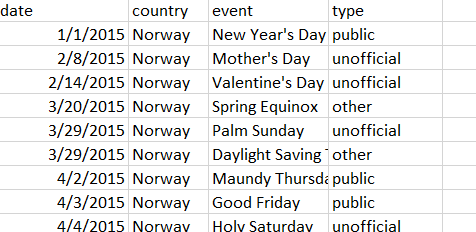

In [ ]:
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
# From https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/298990
def unofficial_hol(df):
    countries = {'Finland': 1, 'Norway': 2, 'Sweden': 3}
    stores = {'KaggleMart': 1, 'KaggleRama': 2}
    products = {'Kaggle Mug': 1,'Kaggle Hat': 2, 'Kaggle Sticker': 3}
    
    # load holiday info.
    hol_path = '../input/publicandunofficialholidaysnorfinswe201519/holidays.csv'
    holiday = pd.read_csv(hol_path)
    
    fin_holiday = holiday.loc[holiday.country == 'Finland']
    swe_holiday = holiday.loc[holiday.country == 'Sweden']
    nor_holiday = holiday.loc[holiday.country == 'Norway']
    df['fin holiday'] = df.date.isin(fin_holiday.date).astype(int)
    df['swe holiday'] = df.date.isin(swe_holiday.date).astype(int)
    df['nor holiday'] = df.date.isin(nor_holiday.date).astype(int)
    df['holiday'] = np.zeros(df.shape[0]).astype(int)
    df.loc[df.country == 'Finland', 'holiday'] = df.loc[df.country == 'Finland', 'fin holiday']
    df.loc[df.country == 'Sweden', 'holiday'] = df.loc[df.country == 'Sweden', 'swe holiday']
    df.loc[df.country == 'Norway', 'holiday'] = df.loc[df.country == 'Norway', 'nor holiday']
    df.drop(['fin holiday', 'swe holiday', 'nor holiday'], axis=1, inplace=True)
    
    return df

## Official holidays must be treated seperately. Note that we spend more money during christmas than regular sunday. 

In [ ]:
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
def get_holidays(df):
    # End of year
    df = pd.concat([df, pd.DataFrame({f"dec{d}":
                      (df.date.dt.month == 12) & (df.date.dt.day == d)
                      for d in range(24, 32)}),
        pd.DataFrame({f"n-dec{d}":
                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Norway')
                      for d in range(24, 32)}),
        pd.DataFrame({f"f-jan{d}":
                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Finland')
                      for d in range(1, 14)}),
        pd.DataFrame({f"jan{d}":
                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Norway')
                      for d in range(1, 10)}),
        pd.DataFrame({f"s-jan{d}":
                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Sweden')
                      for d in range(1, 15)})], axis=1)
    
    # May
    df = pd.concat([df, pd.DataFrame({f"may{d}":
                      (df.date.dt.month == 5) & (df.date.dt.day == d) 
                      for d in list(range(1, 10))}),
        pd.DataFrame({f"may{d}":
                      (df.date.dt.month == 5) & (df.date.dt.day == d) & (df.country == 'Norway')
                      for d in list(range(19, 26))})], axis=1)
    
    # June and July
    df = pd.concat([df, pd.DataFrame({f"june{d}":
                   (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Sweden')
                   for d in list(range(8, 14))})], axis=1)
    
    # Last Wednesday of June
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
    
    df = pd.concat([df, pd.DataFrame({f"wed_june{d}": 
                   (df.date - wed_june_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
                   for d in list(range(-4, 6))})], axis=1)
    
    # First Sunday of November
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
    
    df = pd.concat([df, pd.DataFrame({f"sun_nov{d}": 
                   (df.date - sun_nov_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
                   for d in list(range(0, 9))})], axis=1)
    
    # First half of December (Independence Day of Finland, 6th of December)
    df = pd.concat([df, pd.DataFrame({f"dec{d}":
                   (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Finland')
                   for d in list(range(6, 14))})], axis=1)

    # Easter
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    df = pd.concat([df, pd.DataFrame({f"easter{d}":
                   (df.date - easter_date == np.timedelta64(d, "D"))
                   for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(50, 59))})], axis=1)
    
    return df

### Bit of feature engineering so we can convert the date to numerical values.

In [ ]:
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
def date_feat_eng_X1(df):
    df['year']=df['date'].dt.year                   # 2015 to 2019
    return df

def date_feat_eng_X2(df):
    df['day_of_week']=df['date'].dt.dayofweek       # 0 to 6
    df['day_of_month']=df['date'].dt.day            # 1 to 31
    df['dayofyear'] = df['date'].dt.dayofyear       # 1 to 366
    df.loc[(df.date.dt.year==2016) & (df.dayofyear>60), 'dayofyear'] -= 1   # 1 to 365
    df['week']=df['date'].dt.isocalendar().week     # 1 to 53
    df['week']=df['week'].astype('int')             # int64
    df['month']=df['date'].dt.month                 # 1 to 12
    return df

## As we have seen earlier and below image each country have a differnt range of sales. GDP information can be useful. Below is the data which gives intution on the data

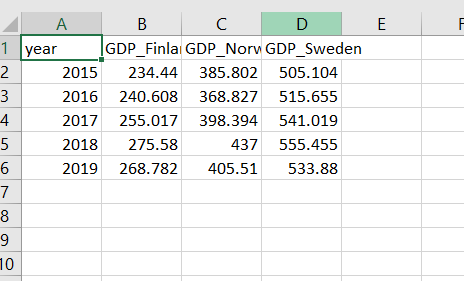

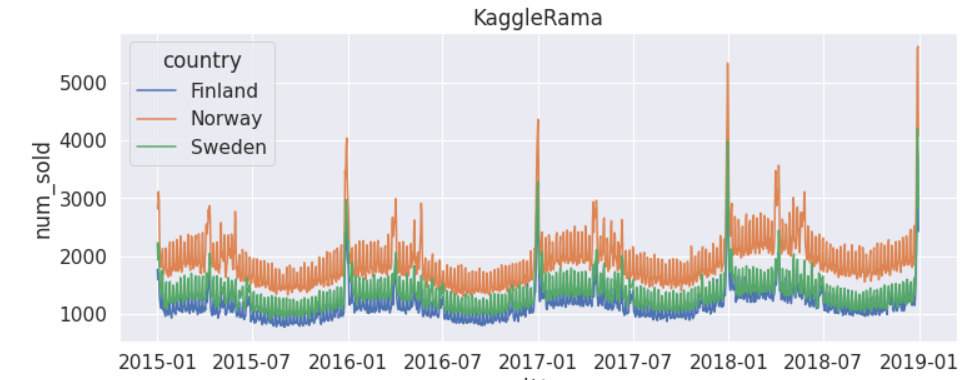

In [ ]:
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
def get_GDP(df):

    # Load data
    GDP_data = pd.read_csv('../input/gdp20152019finlandnorwayandsweden/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv',index_col="year")

    # Rename the columns in GDP df 
    GDP_data.columns = ['Finland', 'Norway', 'Sweden']

    # Create a dictionary
    GDP_dictionary = GDP_data.unstack().to_dict()
    
    df['GDP']=df.set_index(['country', 'year']).index.map(GDP_dictionary.get)
    
    # Split GDP by country (for linear model)
    df['GDP_Finland']=df['GDP'] * (df['country']=='Finland')
    df['GDP_Norway']=df['GDP'] * (df['country']=='Norway')
    df['GDP_Sweden']=df['GDP'] * (df['country']=='Sweden')
    
    df=df.drop('GDP',axis=1)
    
    # Suggested by AmbrosM
    #df['GDP_1212']=df.set_index(['country', 'year']).index.map(GDP_dictionary.get)**1.212

    return df

# A qucik view of the GDP data per country
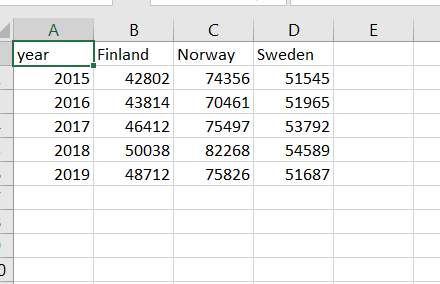

In [ ]:
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
def GDP_PC(df):
    # Load data
    GDP_data = pd.read_csv('../input/gdp-data-2015-to-2019-finland-norway-sweden/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv',index_col="year")

    # Rename the columns in GDP df
    GDP_data.columns = ['Finland', 'Norway', 'Sweden']

    # Create a dictionary
    GDP_dictionary = GDP_data.unstack().to_dict()

    # Create new GDP_PC column
    df['GDP_PC'] = df.set_index(['country', 'year']).index.map(GDP_PC_dictionary.get)
    
    return df

## WE have noticed that the sales are following a typical sin theta wave as shown below. We will use fourier concept to extract some of the features
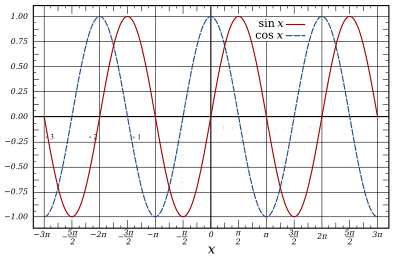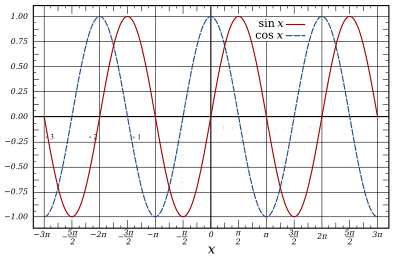

In [ ]:
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
# From https://www.kaggle.com/ambrosm/tpsjan22-03-linear-model#Simple-feature-engineering-(without-holidays)
def FourierFeatures(df):
    # temporary one hot encoding
    for product in ['Kaggle Mug', 'Kaggle Hat']:
        df[product] = df['product'] == product
    
    # The three products have different seasonal patterns
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 2):
        df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * math.pi * k)
        df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * math.pi * k)
        df[f'mug_sin{k}'] = df[f'sin{k}'] * df['Kaggle Mug']
        df[f'mug_cos{k}'] = df[f'cos{k}'] * df['Kaggle Mug']
        df[f'hat_sin{k}'] = df[f'sin{k}'] * df['Kaggle Hat']
        df[f'hat_cos{k}'] = df[f'cos{k}'] * df['Kaggle Hat']
        df=df.drop([f'sin{k}', f'cos{k}'], axis=1)
    
    # drop temporary one hot encoding
    df=df.drop(['Kaggle Mug', 'Kaggle Hat'], axis=1)
    
    return df

In [ ]:
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
# Help linear model find the right height of trends for each combination of features
def get_interactions(df):
    df['KR_Sweden_Mug']=(df.country=='Sweden')*(df['product']=='Kaggle Mug')*(df.store=='KaggleRama')
    df['KR_Sweden_Hat']=(df.country=='Sweden')*(df['product']=='Kaggle Hat')*(df.store=='KaggleRama')
    df['KR_Sweden_Sticker']=(df.country=='Sweden')*(df['product']=='Kaggle Sticker')*(df.store=='KaggleRama')
    df['KR_Norway_Mug']=(df.country=='Norway')*(df['product']=='Kaggle Mug')*(df.store=='KaggleRama')
    df['KR_Norway_Hat']=(df.country=='Norway')*(df['product']=='Kaggle Hat')*(df.store=='KaggleRama')
    df['KR_Norway_Sticker']=(df.country=='Norway')*(df['product']=='Kaggle Sticker')*(df.store=='KaggleRama')
    df['KR_Finland_Mug']=(df.country=='Finland')*(df['product']=='Kaggle Mug')*(df.store=='KaggleRama')
    df['KR_Finland_Hat']=(df.country=='Finland')*(df['product']=='Kaggle Hat')*(df.store=='KaggleRama')
    df['KR_Finland_Sticker']=(df.country=='Finland')*(df['product']=='Kaggle Sticker')*(df.store=='KaggleRama')
    
    df['KM_Sweden_Mug']=(df.country=='Sweden')*(df['product']=='Kaggle Mug')*(df.store=='KaggleMart')
    df['KM_Sweden_Hat']=(df.country=='Sweden')*(df['product']=='Kaggle Hat')*(df.store=='KaggleMart')
    df['KM_Sweden_Sticker']=(df.country=='Sweden')*(df['product']=='Kaggle Sticker')*(df.store=='KaggleMart')
    df['KM_Norway_Mug']=(df.country=='Norway')*(df['product']=='Kaggle Mug')*(df.store=='KaggleMart')
    df['KM_Norway_Hat']=(df.country=='Norway')*(df['product']=='Kaggle Hat')*(df.store=='KaggleMart')
    df['KM_Norway_Sticker']=(df.country=='Norway')*(df['product']=='Kaggle Sticker')*(df.store=='KaggleMart')
    df['KM_Finland_Mug']=(df.country=='Finland')*(df['product']=='Kaggle Mug')*(df.store=='KaggleMart')
    df['KM_Finland_Hat']=(df.country=='Finland')*(df['product']=='Kaggle Hat')*(df.store=='KaggleMart')
    df['KM_Finland_Sticker']=(df.country=='Finland')*(df['product']=='Kaggle Sticker')*(df.store=='KaggleMart')
    
    return df

### Removing date column and  get_dummies() function is used to convert categorical variable into dummy/indicator variables

In [ ]:
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
def dropdate(df):
    df=df.drop('date',axis=1)
    return df
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
def onehot(df,columns):
    df=pd.get_dummies(df, columns)
    return df

In [ ]:
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
# Feature set for trend model
def FeatEng_X1(df):
    df=date_feat_eng_X1(df)
    df=get_GDP(df)
    df=FourierFeatures(df)
    df=get_interactions(df)
    df=dropdate(df)
    df=onehot(df,['store', 'product', 'country'])
    return df

# Feature set for interactions model
def FeatEng_X2(df):
    df=date_feat_eng_X2(df)
    df=get_holidays(df)
    df=unofficial_hol(df)
    df=dropdate(df)
    df=onehot(df,['store', 'product', 'country'])
    return df



In [ ]:
# ref: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model
# Apply feature engineering
X_train_1=FeatEng_X1(X)
X_train_2=FeatEng_X2(X)
X_test_1=FeatEng_X1(test_data)
X_test_2=FeatEng_X2(test_data)

## Lets visualize our data before we start building our model


In [ ]:
# as you can see below, GDP information, sign thera information in included which was not present before. 
# These are the features whcih we have included addtionally
# another thing to note is insteady providing date informaiton we have provided date and sign theta value
X_train_1.head()

In [ ]:
# Simlar to previous step, instead of providing date informaiton we have provided date and day of year, day of the month .... informaiton like that
X_train_2

In [ ]:
X_test_1

In [ ]:
# visualizing our target
y.head()

## I have tried to several options, I will shown one by one. 
## Try 1: Random Forest regressor

In [ ]:

# lets start with random forest model, which is very easy to apply. 
#from sklearn.ensemble import RandomForestRegressor
#clf=RandomForestRegressor(n_estimators=107,
                          #random_state=1337,
                          #max_depth=20,
                          #min_samples_leaf=2,
                          #verbose=2)
#clf.fit(X_train_2,y)      
#predicting the future sales based on the model
#my_pred=clf.predict(X_test_2)
# From https://www.kaggle.com/fergusfindley/ensembling-and-rounding-techniques-comparison
#def geometric_round(arr):
#    result_array = arr
#    result_array = np.where(result_array < np.sqrt(np.floor(arr)*np.ceil(arr)), np.floor(arr), result_array)
#    result_array = np.where(result_array >= np.sqrt(np.floor(arr)*np.ceil(arr)), np.ceil(arr), result_array)
#    return result_array
#_submit=geometric_round(my_pred)
# Save predictions to file
#output = pd.DataFrame({'row_id': X_test_2.index, 'num_sold': _submit})

# Check format
#output.head()
#output.to_csv('submission.csv', index=False)

### I have used gridsearch algorithm to fine tune the hyperparameters of Randomforestregressor. **The Score was 5**
### Then I wanted to try ensemble approad. I started with scaling the data using standrdscaler whcih I will use later

In [ ]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train_2_scaled = scaler.fit_transform(X_train_2)
#X_test_2_scaled = scaler.fit_transform(X_test_2)
#X_train_1_scaled = scaler.fit_transform(X_train_1)
#X_test_1_scaled = scaler.fit_transform(X_test_1)
#print(f'\nDimensions before scaling: \ntrain_set: {X_train_2.shape}\ntest_set: {X_test_2.shape}')
#print(f'\nDimensions after scaling: \ntrain_set: {X_train_2_scaled.shape}\ntest_set: {X_test_2_scaled.shape}')

## Try 2: Apply Ensemble approach with combination of Randomforestregressor with other boosting regressors

In [ ]:
# A class is a collection of properties and methods (like models from Sklearn)
class HybridModel:
    def __init__(self, model_1, model_2, grid=None):
        self.model_1 = model_1
        self.model_2 = model_2
        self.grid=grid
        
    def fit(self, X_train_1, X_train_2, y):
        # Train model 1
        self.model_1.fit(X_train_1, y)
        
        # Predictions from model 1 (trend)
        y_trend = self.model_1.predict(X_train_1)

        if self.grid:
            # Grid search
            tscv = TimeSeriesSplit(n_splits=3)
            grid_model = GridSearchCV(estimator=self.model_2, cv=tscv, param_grid=self.grid)
        
            # Train model 2 on detrended series
            grid_model.fit(X_train_2, y-y_trend)
            
            # Model 2 preditions (for residual analysis)
            y_resid = grid_model.predict(X_train_2)
            
            # Save model
            self.grid_model=grid_model
        else:
            # Train model 2 on residuals
            self.model_2.fit(X_train_2, y-y_trend)
            
            # Model 2 preditions (for residual analysis)
            y_resid = self.model_2.predict(X_train_2)
        
        # Save data
        self.y_train_trend = y_trend
        self.y_train_resid = y_resid
        
    def predict(self, X_test_1, X_test_2):
        # Predict trend using model 1
        y_trend = self.model_1.predict(X_test_1)
        
        if self.grid:
            # Grid model predictions
            y_resid = self.grid_model.predict(X_test_2)
        else:
            # Model 2 predictions
            y_resid = self.model_2.predict(X_test_2)
        
        # Add predictions together
        y_pred = y_trend + y_resid
        
        # Save data
        self.y_test_trend = y_trend
        self.y_test_resid = y_resid
        
        return y_pred

In [ ]:

# Choose models
from sklearn.ensemble import RandomForestRegressor
#model_1=RandomForestRegressor(n_estimators=107,
                          #random_state=1337,
                          #max_depth=20,
                          #min_samples_leaf=2,
                          #verbose=2)
#models_2=[LGBMRegressor(random_state=0), CatBoostRegressor(random_state=0, verbose=False), XGBRegressor(random_state=0)]

# Parameter grid
#param_grid = {'n_estimators': [100],
       # 'max_depth': [4, 6,],
       # 'learning_rate': [0.1]}

# Initialise output vectors
#y_pred=np.zeros(len(test_data))
#train_preds=np.zeros(len(y))

# Ensemble predictions
#for model_2 in models_2:
    # Start timer
#    start = time.time()
    
    # Construct hybrid model
#    model = HybridModel(model_1, model_2, grid=param_grid)

    # Train model
#    model.fit(X_train_1, X_train_2, np.log(y))

    # Save predictions
#    y_pred += np.exp(model.predict(X_test_1,X_test_2))
    
    # Training set predictions (for residual analysis)
#    train_preds += np.exp(model.y_train_trend+model.y_train_resid)
    
    # Stop timer
#    stop = time.time()
    
#    print(f'Model_2:{model_2} -- time:{round((stop-start)/60,2)} mins')
    
#    if model.grid:
#        print('Best parameters:',model.grid_model.best_params_,'\n')
    
# Scale
#y_pred = y_pred/len(models_2)
#train_preds = train_preds/len(models_2)

In [ ]:
# From https://www.kaggle.com/fergusfindley/ensembling-and-rounding-techniques-comparison
#def geometric_round(arr):
    #result_array = arr
    #result_array = np.where(result_array < np.sqrt(np.floor(arr)*np.ceil(arr)), np.floor(arr), result_array)
    #result_array = np.where(result_array >= np.sqrt(np.floor(arr)*np.ceil(arr)), np.ceil(arr), result_array)
    #return result_array

#y_pred=geometric_round(y_pred)
# Save predictions to file
#output = pd.DataFrame({'row_id': test_data.index, 'num_sold': y_pred})

# Check format
#output.head()
#output.to_csv('submission.csv', index=False)

## Try3: This time lets use scaled data and see does it improve any performance?

In [ ]:
# Choose models
#model_1=RandomForestRegressor(n_estimators=107,
                          #random_state=1337,
                          #max_depth=20,
                          #min_samples_leaf=2,
                          #verbose=2)
#models_2=[LGBMRegressor(random_state=0), CatBoostRegressor(random_state=0, verbose=False), XGBRegressor(random_state=0)]

# Parameter grid
#param_grid = {'n_estimators': [100],
        #'max_depth': [4, 6,],
        #'learning_rate': [0.1]}

# Initialise output vectors
#y_pred=np.zeros(len(test_data))
#train_preds=np.zeros(len(y))

# Ensemble predictions
#for model_2 in models_2:
    # Start timer
    #start = time.time()
    
    # Construct hybrid model
    #model = HybridModel(model_1, model_2, grid=param_grid)

    # Train model
    #model.fit(X_train_1_scaled, X_train_2_scaled, np.log(y))

    # Save predictions
    #y_pred += np.exp(model.predict(X_test_1_scaled,X_test_2_scaled))
    
    # Training set predictions (for residual analysis)
    #train_preds += np.exp(model.y_train_trend+model.y_train_resid)
    
    # Stop timer
    #stop = time.time()
    
    #print(f'Model_2:{model_2} -- time:{round((stop-start)/60,2)} mins')
    
    #if model.grid:
    #    print('Best parameters:',model.grid_model.best_params_,'\n')
    
# Scale
#y_pred_scaled = y_pred/len(models_2)
#train_preds_scaled = train_preds/len(models_2)
#y_pred_scaled=geometric_round(y_pred_scaled)
# Save predictions to file
#output = pd.DataFrame({'row_id': test_data.index, 'num_sold': y_pred_scaled})

# Check format
#output.head()
#output.to_csv('submission.csv', index=False)

# Score was 5.20, not an improvement from previous models

## Try4: Now trying linear regression with Randomforest+LGBM+Catboost+XGB)

In [ ]:
# Choose models
model_1=LinearRegression()
#models_2=[LGBMRegressor(random_state=0), CatBoostRegressor(random_state=0, verbose=False), XGBRegressor(random_state=0)]
models_2=[LGBMRegressor(random_state=0), CatBoostRegressor(random_state=0, verbose=False), XGBRegressor(random_state=0),RandomForestRegressor(random_state=1337)]

# Parameter grid
param_grid = {'n_estimators': [100],
        'max_depth': [4, 6,]}

# Initialise output vectors
y_pred=np.zeros(len(test_data))
train_preds=np.zeros(len(y))

# Ensemble predictions
for model_2 in models_2:
    # Start timer
    start = time.time()
    
    # Construct hybrid model
    model = HybridModel(model_1, model_2, grid=param_grid)

    # Train model
    model.fit(X_train_1, X_train_2, np.log(y))

    # Save predictions
    y_pred += np.exp(model.predict(X_test_1,X_test_2))
    
    # Training set predictions (for residual analysis)
    train_preds += np.exp(model.y_train_trend+model.y_train_resid)
    
    # Stop timer
    stop = time.time()
    
    print(f'Model_2:{model_2} -- time:{round((stop-start)/60,2)} mins')
    
    if model.grid:
        print('Best parameters:',model.grid_model.best_params_,'\n')
    
# Scale
y_pred_RF = y_pred/len(models_2)
train_preds_RF = train_preds/len(models_2)
# From https://www.kaggle.com/fergusfindley/ensembling-and-rounding-techniques-comparison
def geometric_round(arr):
    result_array = arr
    result_array = np.where(result_array < np.sqrt(np.floor(arr)*np.ceil(arr)), np.floor(arr), result_array)
    result_array = np.where(result_array >= np.sqrt(np.floor(arr)*np.ceil(arr)), np.ceil(arr), result_array)
    return result_array
y_pred_RF=geometric_round(y_pred_RF)
# Save predictions to file
output = pd.DataFrame({'row_id': test_data.index, 'num_sold': y_pred_RF})

# Check format
output.head()
output.to_csv('submission.csv', index=False)

## wow the Score is 4.63143. This is the best so far. 

## lessons learned 
## * A single algorithum might not work. Better to go for Ensemble
## * Fine tuning hyperparameters helps but its not game changer 
## * Focus on feature engineering 